In [ ]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import tensorflow.keras.backend as K
import keras.backend as K

In [ ]:
# Cargar el dataset
df = pd.read_csv("ProductPriceIndex.csv")

In [ ]:
# Convertir la columna de fecha al formato correcto
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)

<ipython-input-5-1d3fa3639f55>:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)


In [ ]:
# Eliminar signos de dólar y porcentajes de las columnas de precios
cols_to_clean = ['farmprice', 'atlantaretail', 'chicagoretail', 'losangelesretail', 'newyorkretail', 'averagespread']
df[cols_to_clean] = df[cols_to_clean].replace('[\$,%]', '', regex=True)

# Convertir las columnas de precios a flotantes y manejar valores nulos
df[cols_to_clean] = df[cols_to_clean].apply(pd.to_numeric, errors='coerce')

# Eliminar filas con valores nulos
df = df.dropna()


In [ ]:
# Filtrar datos hasta el año 2019
df_historico = df[df['date'].dt.year < 2020]

# Dividir los datos en características (X) y la variable objetivo (y)
X = df_historico[['farmprice', 'atlantaretail', 'chicagoretail', 'newyorkretail', 'averagespread']]
y = df_historico['losangelesretail']


In [ ]:
# Excluir la columna de fecha y la columna productname de las características
X = df_historico.drop(['date', 'productname'], axis=1)

# Normalizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
#for col in df.columns:
 #   unique_values = df[col].unique()
  #  print(f"Valores únicos en {col}: {unique_values}")

In [ ]:
# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Definir el modelo de red neuronal
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(32, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(1)
])

In [ ]:
# Compilar el modelo
#model.compile(optimizer='adam', loss='mean_squared_error')

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

# Definir la métrica R^2
def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.epsilon()))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[r_square])

# Definir función de pérdida personalizada para el MAPE
#def mean_absolute_percentage_error(y_true, y_pred):
  #  y_true = K.flatten(y_true)
 #   y_pred = K.flatten(y_pred)
 #   return K.mean(K.abs((y_true - y_pred) / K.clip(K.abs(y_true), K.epsilon(), None))) * 100


# Compilar el modelo con la función de pérdida personalizada (MAPE)
#model.compile(optimizer='adam', loss=mean_absolute_percentage_error)

In [ ]:
# Entrenar el modelo
model.fit(X_train, y_train, epochs=80, batch_size=64, verbose=1)

Epoch 1/80
173/173 [==============================] - 2s 3ms/step - loss: 2.0541 - r_square: 0.3003
Epoch 2/80
173/173 [==============================] - 0s 3ms/step - loss: 1.2463 - r_square: 0.8906
Epoch 3/80
173/173 [==============================] - 1s 3ms/step - loss: 0.9388 - r_square: 0.9650
Epoch 4/80
173/173 [==============================] - 0s 3ms/step - loss: 0.7331 - r_square: 0.9811
Epoch 5/80
173/173 [==============================] - 1s 3ms/step - loss: 0.5863 - r_square: 0.9763
Epoch 6/80
173/173 [==============================] - 1s 3ms/step - loss: 0.4677 - r_square: 0.9822
Epoch 7/80
173/173 [==============================] - 1s 3ms/step - loss: 0.3880 - r_square: 0.9710
Epoch 8/80
173/173 [==============================] - 1s 4ms/step - loss: 0.3116 - r_square: 0.9836
Epoch 9/80
173/173 [==============================] - 1s 5ms/step - loss: 0.2621 - r_square: 0.9798
Epoch 10/80
173/173 [==============================] - 1s 5ms/step - loss: 0.2176 - r_square: 0.9839

In [ ]:
# Evaluar el modelo en el conjunto de prueba
# Obtener el R^2 en el conjunto de prueba
loss, r2_score_test = model.evaluate(X_test, y_test)
print("Error de prueba:", loss,"R^2 en el conjunto de prueba:", r2_score_test)

148/148 [==============================] - 0s 2ms/step - loss: 0.0556 - r_square: 0.9652
Error de prueba: 0.05561908334493637 R^2 en el conjunto de prueba: 0.965201199054718


In [ ]:
# Predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Guardar el modelo entrenado
model.save("initial_model.h5")
# Cargar el modelo entrenado
loaded_model = tf.keras.models.load_model("initial_model.h5", custom_objects={'root_mean_squared_error': root_mean_squared_error, 'r_square': r_square})

# Descongelar algunas capas para fine-tuning
for layer in loaded_model.layers[:-2]: # Descongelamos todas las capas excepto las últimas dos
    layer.trainable = True

# Compilar el modelo para fine-tuning
loaded_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss=root_mean_squared_error, metrics=[r_square])

# Fine-tuning
history_finetune = loaded_model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=1)

# Evaluar el modelo fine-tuned en el conjunto de prueba
loss_finetune = loaded_model.evaluate(X_test, y_test)
print("Error de prueba después de fine-tuning:", loss_finetune)

# Predicciones en el conjunto de prueba después de fine-tuning
y_pred_finetune = loaded_model.predict(X_test)

# Obtener las fechas, nombres de los productos, valores reales y predicciones correspondientes al conjunto de prueba
comparison_df = pd.DataFrame({'Date': df_historico.loc[X_test.index, 'date'],
                              'Product': df_historico.loc[X_test.index, 'productname'],
                              'Actual': y_test.values,
                              'Predicted': y_pred_finetune.flatten()},
                             index=X_test.index)

# Ordenar los resultados por fecha
comparison_df_sorted = comparison_df.sort_values(by='Date')

# Imprimir el DataFrame resultante
print(comparison_df_sorted)


148/148 [==============================] - 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/20
173/173 [==============================] - 2s 3ms/step - loss: 0.2361 - r_square: 0.8900
Epoch 2/20
173/173 [==============================] - 0s 3ms/step - loss: 0.2066 - r_square: 0.9455
Epoch 3/20
173/173 [==============================] - 1s 3ms/step - loss: 0.1711 - r_square: 0.9647
Epoch 4/20
173/173 [==============================] - 0s 3ms/step - loss: 0.1490 - r_square: 0.9766
Epoch 5/20
173/173 [==============================] - 1s 3ms/step - loss: 0.1511 - r_square: 0.9733
Epoch 6/20
173/173 [==============================] - 0s 3ms/step - loss: 0.1562 - r_square: 0.9744
Epoch 7/20
173/173 [==============================] - 1s 3ms/step - loss: 0.1554 - r_square: 0.9749
Epoch 8/20
173/173 [==============================] - 0s 3ms/step - loss: 0.1679 - r_square: 0.9703
Epoch 9/20
173/173 [==============================] - 0s 3ms/step - loss: 0.1531 - r_square: 0.9760
Epoch 10/20
173/173 [==============================] - 1s 4ms/step - loss: 0.1463 - r_square: 0.9780

In [ ]:
# Guardar el DataFrame en un archivo CSV
#comparison_df_sorted.to_csv('comparison_df_sorted.csv', index=False)

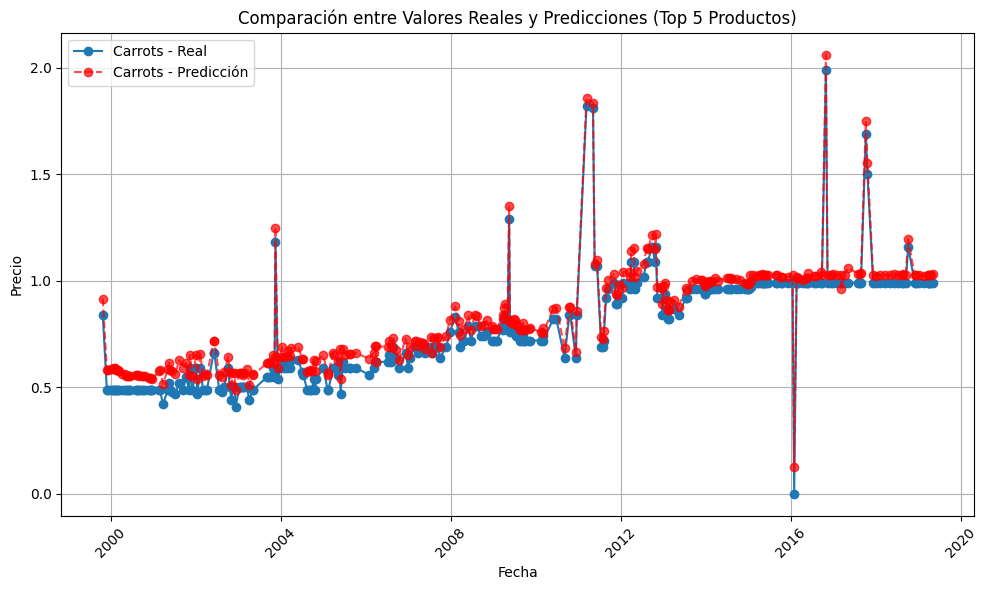

In [ ]:
# Obtener solo los primeros 5 productos
top_5_products = comparison_df_sorted['Product'].unique()[:1]
comparison_df_top_5 = comparison_df_sorted[comparison_df_sorted['Product'].isin(top_5_products)]

# Graficar los valores reales y las predicciones para cada producto
plt.figure(figsize=(10, 6))
colors = plt.cm.tab10.colors[:3]  # Tomar los primeros 5 colores de la paleta 'tab10'
for i, product_name in enumerate(comparison_df_top_5['Product'].unique()):
    product_data = comparison_df_top_5[comparison_df_top_5['Product'] == product_name]
    color = colors[i]  # Seleccionar el color correspondiente al producto
    plt.plot(product_data['Date'], product_data['Actual'], marker='o', linestyle='-', color=color, label=f'{product_name} - Real')
    plt.plot(product_data['Date'], product_data['Predicted'], marker='o', linestyle='--', color='red', label=f'{product_name} - Predicción', alpha=0.7)  # Cambiar el color de la predicción a rojo y reducir la opacidad

plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.title('Comparación entre Valores Reales y Predicciones (Top 5 Productos)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


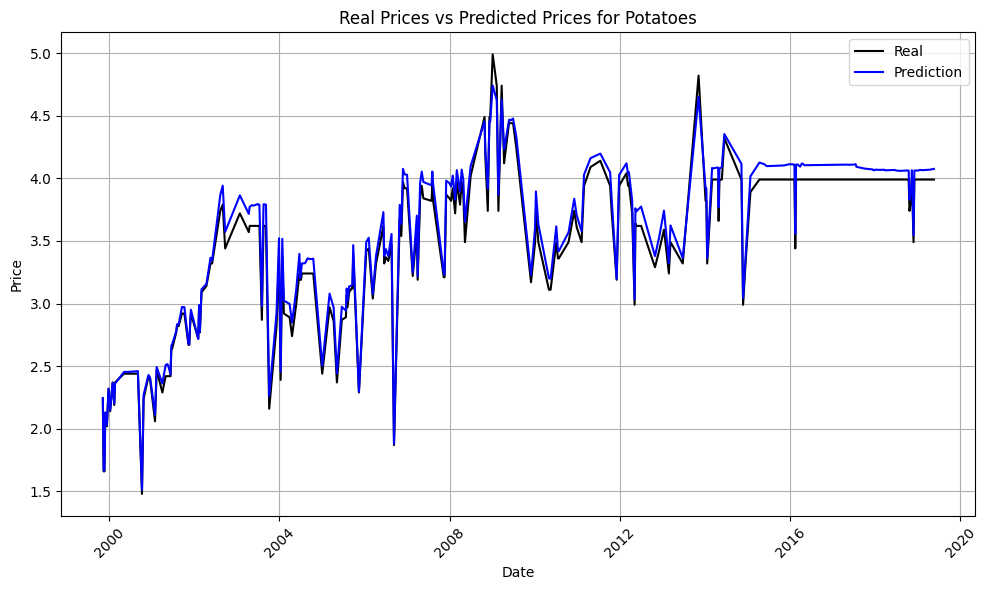

In [ ]:
def plot_product_predictions(comparison_df, product_name):
    # Filtrar el DataFrame para obtener solo los datos del producto seleccionado
    product_data = comparison_df[comparison_df['Product'] == product_name]

    # Graficar los valores reales y las predicciones para el producto seleccionado
    plt.figure(figsize=(10,6))
    plt.plot(product_data['Date'], product_data['Actual'], linestyle='-', color='black', label='Real')
    plt.plot(product_data['Date'], product_data['Predicted'], linestyle='-', color='blue', label='Prediction')

    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'Real Prices vs Predicted Prices for {product_name}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Ejemplo de uso
#product_name = 'Cauliflower'  # Cambiar este valor por el nombre del producto que deseas visualizar
#product_name = 'Avocados'
#product_name = 'Broccoli Crowns'
#product_name = 'Carrots'
#product_name = 'Oranges'
product_name = 'Potatoes'
plot_product_predictions(comparison_df_sorted, product_name)

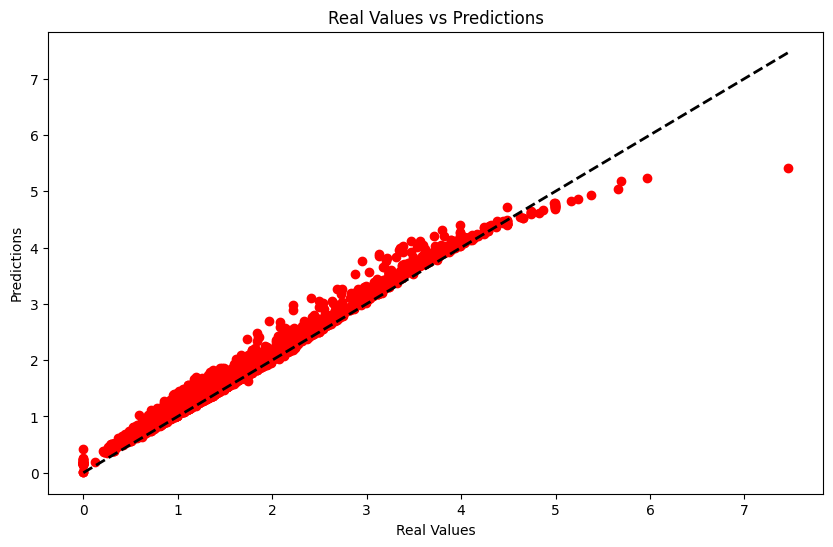

In [ ]:
# Graficar los valores reales vs predicciones
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='red')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Real Values')
plt.ylabel('Predictions')
plt.title('Real Values vs Predictions')
plt.show()
